# Imports

In [322]:
!pip install keras-tuner

In [323]:
from google.colab import drive
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display #check to see if this is used
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
import tensorflow as tf
import numpy as np
import html
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import pickle
from tensorflow import keras
import keras_tuner as kt

#### Configure for reproducibility

In [324]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()


# Loading Data

In [325]:
#drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [326]:
df_train_data = pd.read_csv('data/train.csv')


In [327]:
df_train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [328]:
df_train_data.shape

(7613, 5)

In [329]:
df_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [330]:
df_test_data = pd.read_csv('data/test.csv')

In [331]:
df_test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [332]:
df_test_data.shape

(3263, 4)

In [333]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [334]:
df_sample_submission = pd.read_csv('data/sample_submission.csv')

In [335]:
df_sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [336]:
df_sample_submission.shape

(3263, 2)

In [337]:
df_sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


# Problem Statement & Data Description

The goal with this project is to build a bidirectional GRU model and a bidirectional LSTM model and compare architecture performance. The architecture that more accurately predicts whether or not each tweet in the testing dataset is about a real disaster, measured by the model's F1 score, will be considered the better model.

There are three data files:

- **A training set of 7,613 records and 5 fields:**
  - `id`: an integer value that is a unique identifier for each tweet  
  - `keyword`: a string that contains a keyword from the tweet; this field may be blank (NaN)  
  - `location`: a string that contains the location the tweet was sent from; this field may be blank (NaN)  
  - `text`: a string that contains the text of the tweet  
  - `target`: an integer value of either 1 or 0 which indicates whether the tweet is about a real disaster (1) or not (0)  

- **A testing set of 3,263 records with 4 fields:**
  - `id`: an integer variable that is a unique identifier for each tweet  
  - `keyword`: a string that contains a keyword from the tweet; this field may be blank (NaN)  
  - `location`: a string that contains the location the tweet was sent from; this field may be blank (NaN)  
  - `text`: a string that contains the text of the tweet  

- **A sample submission** of 2 fields consisting of the testing data `id`s and their predicted `target`


# Data Cleaning

### Check for Duplicates

We will first check for any duplicates in our dataset. With this process, we will take a relatively conservative approach and only consider the record a duplicate if its text, location and keyword are exactly the same as another record.

In [338]:
num_duplicates = df_train_data.duplicated(subset=['text', 'location', 'keyword']).sum()
print(f"Number of duplicates where text, location, and keyword all match: {num_duplicates}")

Number of duplicates where text, location, and keyword all match: 61


In [339]:
percent_dup = num_duplicates/len(df_train_data)*100
print(f"Percentage of duplicates where text, location, and keyword all match: {percent_dup}")

Percentage of duplicates where text, location, and keyword all match: 0.8012610009194797


In [340]:
df_deduped = df_train_data.drop_duplicates(subset= ['text', 'location', 'keyword'], keep='first')

In [341]:
rows_removed = len(df_train_data) - len(df_deduped)
print(f"Rows removed: {rows_removed}")

Rows removed: 61


In [342]:
df_train_data = df_deduped

In [343]:
records = len(df_train_data)
print(f"Records in updated training data: {records}")

Records in updated training data: 7552


#### Duplicates Summary

Less than 1% of the records were duplicates. These duplicates were removed, leaving us with 7,552 tweets in the training data.

### Check for Missing Values

In [344]:
print(df_train_data.isnull().sum())

id             0
keyword       61
location    2493
text           0
target         0
dtype: int64


#### Missing Values Summary

There are missing values in both the keyword and location fields, however since we will be training on the text field this is not of concern.

### Data Cleaning Summary

A conservative approach to deduplicating was used in that a record was only considered to be a duplicate if it was an exact match across the fields `keyword`, `location`, and `text`. 61 duplicates were removed from the training data set using this approach. The `keyword` and `location` fields both have missing values with `location` having the most. Since the model will be trained on the `text` field, there was not any cleaning done on the missing values in `location` and `keyword`.

# EDA

During the EDA process we will:

- Look at distribution of target categories
- Look at word distribution for dataset
- Look at word distribution for each target category
- Look at location for each target category

### Target Distribution

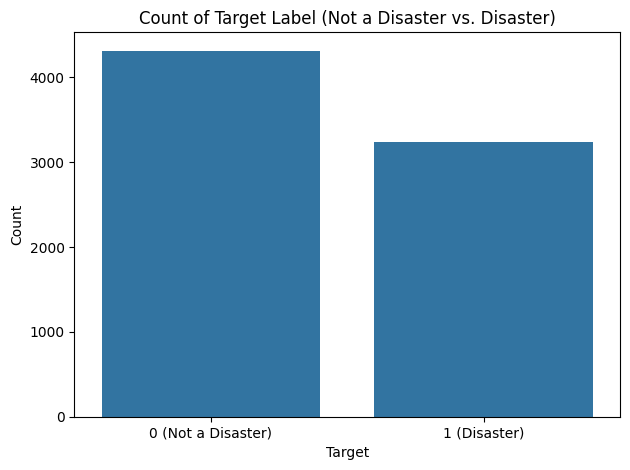

In [345]:
ax = sns.countplot(x='target', data=df_train_data)
ax.set_xticks([0, 1])
ax.set_xticklabels(['0 (Not a Disaster)', '1 (Disaster)'])

plt.title('Count of Target Label (Not a Disaster vs. Disaster)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

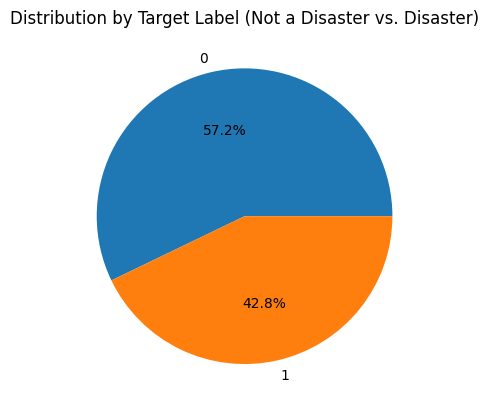

In [346]:
train_data_grpd = df_train_data.groupby('target').size()
percentages = train_data_grpd / train_data_grpd.sum() * 100

plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%')
plt.title('Distribution by Target Label (Not a Disaster vs. Disaster)')
plt.show()

#### Distribution Summary
From the count barplot and the distribution pie chart, we can see that the classes are fairly balanced at 57% of the labels being not a disaster and 43% being a disaster.

### Word Statistics & Distribution

Next, we will look at the distribution of words within the target categories. Our aim is to discern if there are any identifiable key differences in terms. We will start with some summary statistics.

#### Word Statistics

In [347]:
def text_stats(texts):
    all_words = ' '.join(texts).lower().split()
    word_counts = texts.apply(lambda x: len(x.split()))
    mean_word_count = word_counts.mean()
    median_word_count = word_counts.median()
    unique_word_count = len(set(all_words))
    unique_word_percentage = round(unique_word_count / len(all_words) * 100, 2)
    most_common_word = Counter(all_words).most_common(1)[0][0] if all_words else None

    stopword_count = sum(1 for word in all_words if word in ENGLISH_STOP_WORDS)
    stopword_percentage = round(stopword_count / len(all_words) * 100, 2) if all_words else 0


    return pd.Series({
        'Avg Word Count': mean_word_count,
        'Median Word Count': median_word_count,
        'Most Common Word': most_common_word,
        'Unique Word Percent': unique_word_percentage,
        'Stopword Percent': stopword_percentage

    })


In [348]:
target_stats = df_train_data.groupby('target')['text'].apply(text_stats).reset_index()
df_target_stats_long = pd.DataFrame(target_stats)
df_target_stats_wide = df_target_stats_long.pivot(index='target', columns='level_1', values='text')
df_target_stats_wide.columns.name = None
df_target_stats_wide.sort_values(by='Avg Word Count', ascending=False, inplace = True)

In [349]:
df_target_stats_wide

,Avg Word Count,Median Word Count,Most Common Word,Stopword Percent,Unique Word Percent
target,,,,,
1,15.151731,15.0,the,30.09,29.14
0,14.690222,15.0,the,35.55,28.3


#### Word Statistics Summary

We can see from the word statistics summary that the tweets labeled 1 versus the tweets labeled 0 are not largely different. They share the same median word count, their averages are not far off from each other, likewise the percentage of stopwords are similar as well as the percent of unique words used. Because there is a large percentage of stopwords for both sets and the most common word is the, we will need to remove the stopwords in the preprocessing stage. Now that we can see the statistics are relatively similiar, lets plot the disitribution of length by target to see if they too are similar or different.

### Distribution of Length of Tweets

In [350]:
df_train_data['text_length'] = df_train_data['text'].str.len()

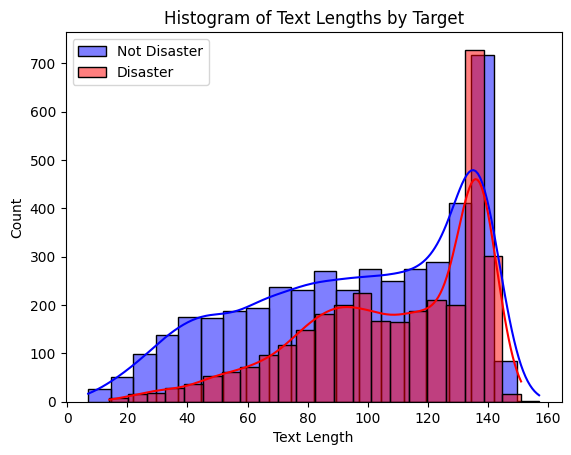

In [351]:
sns.histplot(data=df_train_data[df_train_data['target']==0]['text_length'], kde=True, color='blue', label='Not Disaster')
sns.histplot(data=df_train_data[df_train_data['target']==1]['text_length'], kde=True, color='red', label='Disaster')
plt.legend()
plt.title("Histogram of Text Lengths by Target")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

#### Distribution Summary

The distributions of the disaster and not disaster groups appear relatively similiar. They both are left-skewed distributions that peak in close to the same point at a length just short of 140 characters. This intuitively makes sense as the original maximum tweet length was 140 characters.

### Top 10 Words by Category

In [352]:
def top_10_words_by_target(df):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    for idx, target_val in enumerate([1, 0]):
        subset = df[df['target'] == target_val]
        text = ' '.join(subset['text'].astype(str))  # Replace 'text' if your column has a different name

        # CountVectorizer with stopwords
        vectorizer = CountVectorizer(lowercase=True, stop_words='english')
        X = vectorizer.fit_transform([text])
        word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))

        # Get top 10
        top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]
        words, freqs = zip(*top_words)

        # Plotting
        ax[idx].bar(words, freqs)
        ax[idx].set_title(f"Top 10 Words (target = {target_val})")
        ax[idx].set_xlabel("Frequency")

    plt.tight_layout()
    plt.show()

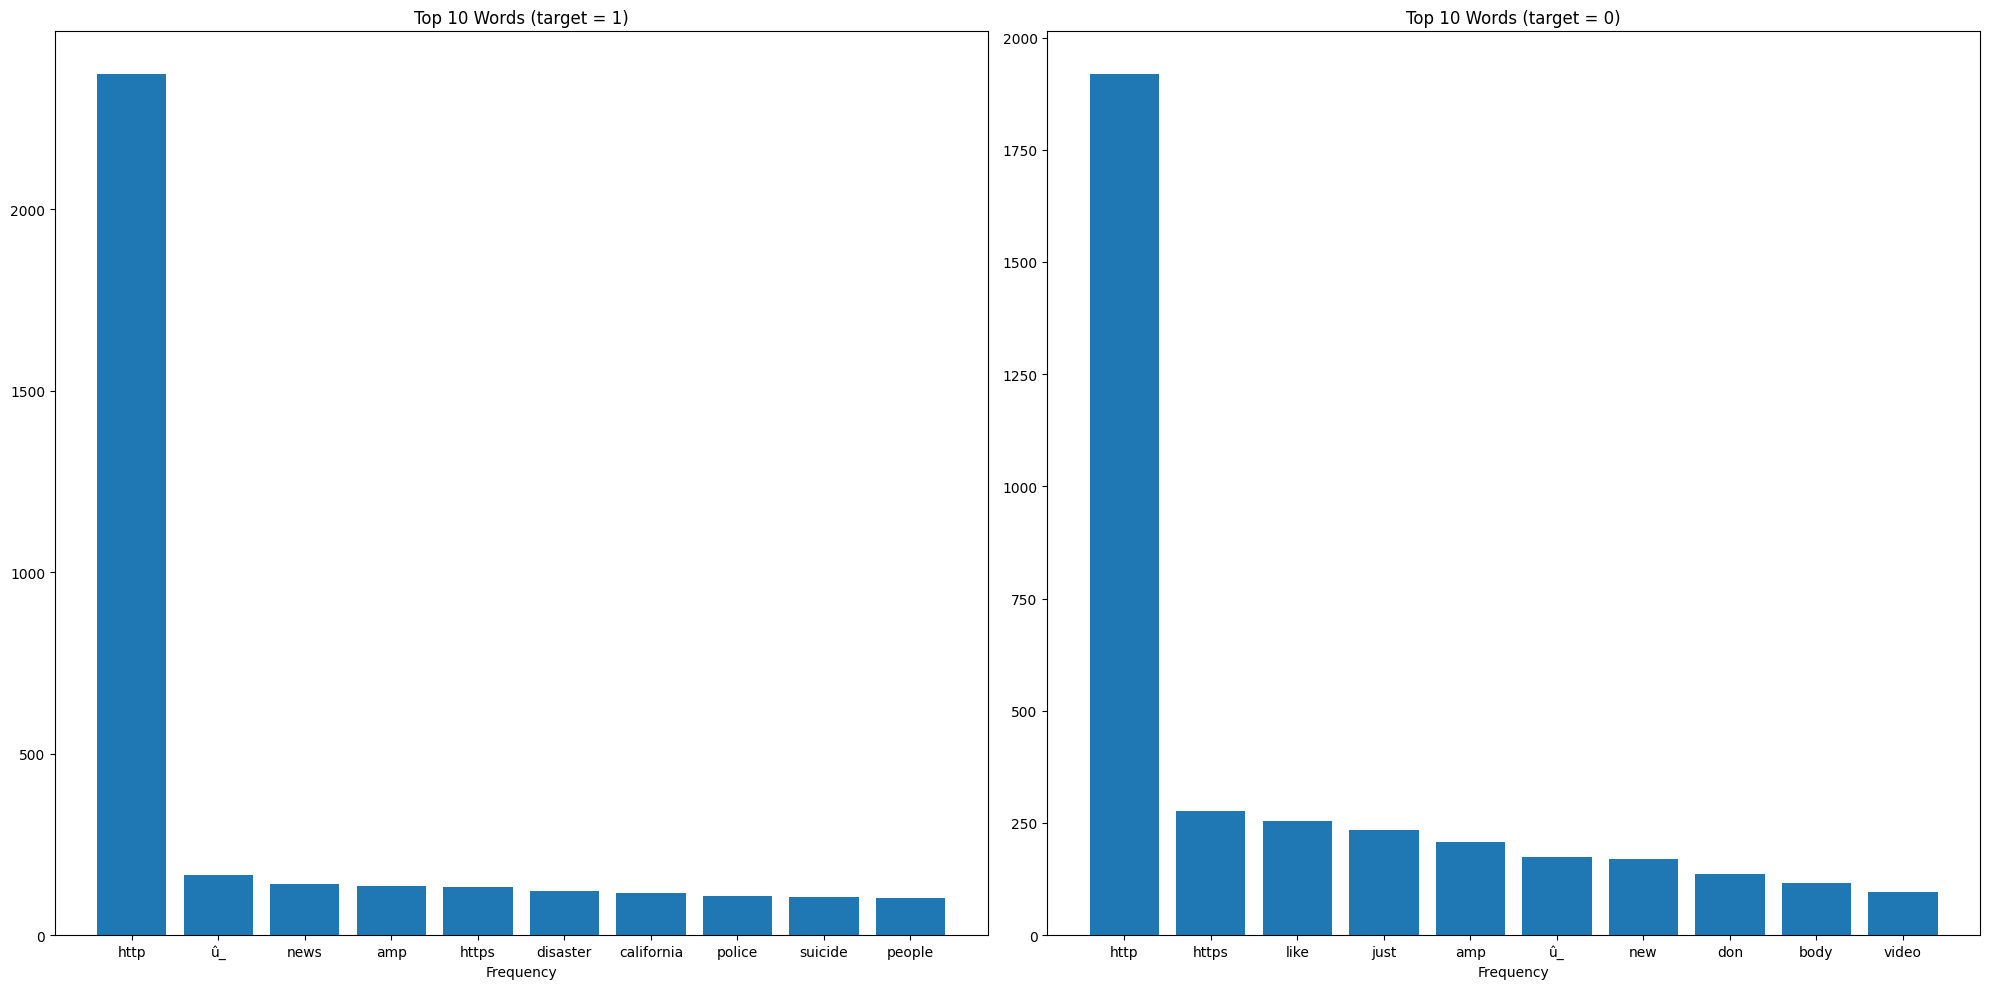

In [353]:
top_10_words_by_target(df_train_data)

#### Top 10 Summary

While the top 10 summary does show there are some key word differences between the two datasets, for example terms like 'disaster', 'police' and 'suicide' are some of the top words in the data labeled disaster while words like 'like', 'just' and 'new' are top words in the data labeled not disaster, it more than anything sheds light on the preprocessing that will need to be done. We can see http, https, amp (as in ampersand) and $\hat{u}$_ across both labels and these will need to be removed prior to modeling to ensure the cleanest dataset possible.

### EDA Summary

Through EDA, we discovered:

- The labels were evenly distributed
- The summary statistics for the target labels are similar
- The distribution of the length for the target labels are similar
- The top 10 words by label showed the need for additional preprocessing on the texts

# Preprocessing

During the preprocessing stage we will create a clean_tweet function that does the following:

- Removes URLs
- Removes reserved words
- Converts text to lowercase
- Removes @  and # symbols
- Removes non-alphanumeric characters
- Strips extra whitespace
- Tokenizes the text
- Removes stopwords
- Lemmatizes the tokens

We will then need to prepare the data for the model building process by converting it to tf.data.Dataset and splitting it into a validation and training set.

In [354]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [355]:
def clean_tweet(text):

    text = html.unescape(text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'\bRT\b|\bFAV\b', '', text)
    text = text.lower()
    text = re.sub(r'@(\w+)', r'\1', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = text.split()
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(cleaned_tokens)


In [356]:
df_train_data['clean_text'] = df_train_data['text'].apply(clean_tweet)

In [357]:
df_train_data.head()

,id,keyword,location,text,target,text_length,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,resident asked shelter place notified officers...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,"13,000 people receive wildfire evacuation orde..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfire pour...


#### Prepare Data for TensorFlow Processes

In [358]:
#Convert pandas dataframe to tf.dataset
X = df_train_data['clean_text']
y = df_train_data['target']

dataset = tf.data.Dataset.from_tensor_slices((X.values, y.values))

####  Create Validation Data from Training Data

We will shuffle and then split the data 80/20 (80% training, 20% validation)

In [359]:
total_size = len(df_train_data)
train_size = int(0.8 * total_size)

dataset = dataset.shuffle(buffer_size=total_size, seed=SEED)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Model Building

## LSTM with a Bidirectional Wrapper

We will build our first model using an LSTM architecture with a bidirectional wrapper like the example in Tensorflow's text classification with RNNs documentation. We will use the F1 score to identify the best model as this is the metric the competition uses to score on the test data.

In [360]:
BATCH_SIZE = 32

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [361]:
train_dataset = train_dataset.map(lambda x, y: (x, tf.expand_dims(y, -1)))
val_dataset = val_dataset.map(lambda x, y: (x, tf.expand_dims(y, -1)))

Our initial vocabulary size will 5000, meaning the top 5000 words will be used to build the model.

In [362]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))


In [363]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'like', 'fire', 'im', 'get', 'via', 'new', 'dont',
       'people', 'one', 'u', 'news', 'video', 'disaster', 'emergency',
       '2', 'time', 'body', 'police'], dtype='<U27')

### Build & Compile the BiLSTM Model

In [364]:
tf.random.set_seed(SEED)
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [365]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score', average='micro', threshold=0.5)]
)

### Fit BiLSTM Model

When we fit the model we will use a checkpoint to monitor the F1 score at each epoch and save the best model. In addition, we will use early stop to end the fitting process if the F1 score does not improve after 3 epochs.

In [366]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "models/best_model_LSTM_bidirectional.keras",
    monitor="val_f1_score",
    mode="max",
    save_best_only=True,
    save_weights_only=False,
    verbose = 1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_f1_score",
    mode="max",
    patience=3,
    restore_best_weights=True,
    verbose = 1
)

In [367]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/10
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6810 - f1_score: 0.4176 - loss: 0.6038
Epoch 1: val_f1_score improved from -inf to 0.81921, saving model to /content/drive/My Drive/my_models/best_model_LTSM_bidirectional.keras
189/189 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.6817 - f1_score: 0.4200 - loss: 0.6030 - val_accuracy: 0.8630 - val_f1_score: 0.8192 - val_loss: 0.3552
Epoch 2/10
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8636 - f1_score: 0.8321 - loss: 0.3487
Epoch 2: val_f1_score improved from 0.81921 to 0.87910, saving model to /content/drive/My Drive/my_models/best_model_LTSM_bidirectional.keras
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.8635 - f1_score: 0.8319 - loss: 0.3488 - val_accuracy: 0.9001 - val_f1_score: 0.8791 - val_loss: 0.2772
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8960 - f1_score: 0.8729 - loss: 0.2730
Epoch 3: val_f1_score improved from 0.87910 to 0.91715, saving model to /conten

In [368]:
with open('models/history_lstm_bidirectional.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [369]:
#Load History (Needed if in New Session)
with open('models/history_lstm_bidirectional.pkl', 'rb') as f:
    history_dict = pickle.load(f)

In [370]:
#print(history.history.keys())

### Evaluate Plots of BiLSTM

Now that we've found our best BiLSTM model, lets inspect the accuracy, loss and F1 score plots

In [371]:
train_f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']
epochs_range = range(1, len(train_f1) + 1)

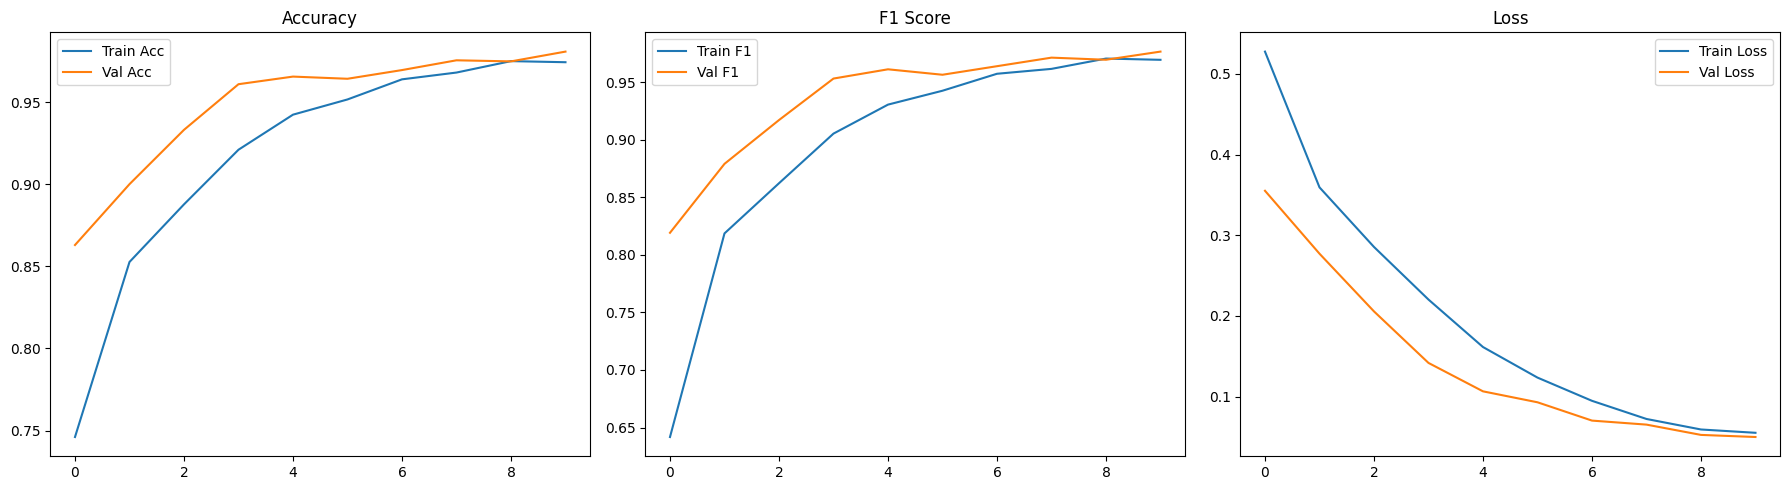

In [372]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axs[0].plot(history.history['accuracy'], label='Train Acc')
axs[0].plot(history.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Accuracy')
axs[0].legend()

# F1 Score
axs[1].plot(history.history['f1_score'], label='Train F1')
axs[1].plot(history.history['val_f1_score'], label='Val F1')
axs[1].set_title('F1 Score')
axs[1].legend()

# Loss
axs[2].plot(history.history['loss'], label='Train Loss')
axs[2].plot(history.history['val_loss'], label='Val Loss')
axs[2].set_title('Loss')
axs[2].legend()

plt.tight_layout()
plt.show()

#### BiLSTM Plots Summary
The plots indicate the model is performing well in that accuracy, and F1 score increase (in the case of loss, decrease) before beginning to level off and remain stable. We are not seeing a continued large rise (fall) in the scores as we reach epoch 10, indicating additional epochs are not needed.

### Build a Confusion Matrix

Now that we have a feel for the performance of the evaluation metrics, lets dig deeper and look at a confusion matrix. Inspecting this will help us understand the distribution of false positives and false negatives.

In [373]:
model = keras.models.load_model('models/best_model_LSTM_bidirectional.keras')


In [374]:
y_true_og = []
y_pred_og = []

for text_batch, label_batch in val_dataset:
    preds = model.predict(text_batch)
    y_true_og.extend(label_batch.numpy())
    y_pred_og.extend((preds > 0.5).astype("int").flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

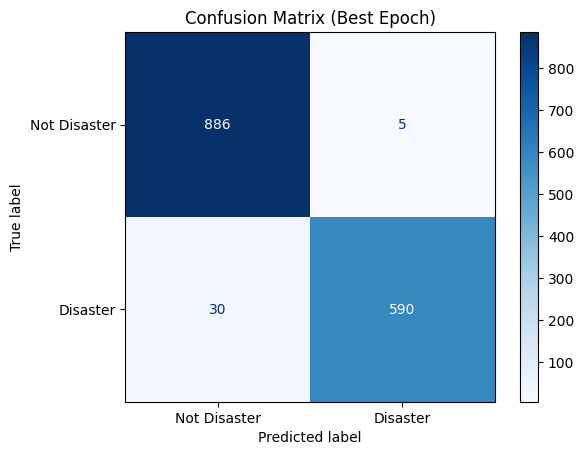

In [375]:
cm = confusion_matrix(y_true_og, y_pred_og)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Best Epoch)")
plt.grid(False)
plt.show()

#### BiLSTM Confusion Matrix Summary

There are very few false positives (only 5) as well as very few false negatives (30). Indicating that 97.7% of the tweets were correctly labeled. That being said, there are 6 times as many false negatives as false positives which indicates the model struggles to identify positives more than negatives.


### Predict on Testing Data (BiLSTM)

Since we achieved a high F1 score on the initial model, we are going to go ahead and predict on the testing data.

#### Clean the testing data

In [ ]:
df_test_data['clean_text'] = df_test_data['text'].apply(clean_tweet)

#### Use model.predict to predict on the testing data

In [ ]:
test_text = df_test_data['clean_text']
pred_LSTM_bidir = model.predict(np.array(test_text))

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


#### Generate submission file

In [ ]:
submission_lstm_bidir = pd.DataFrame({
    'id': df_test_data['id'],
    'target': (pred_LSTM_bidir > 0.5).astype(int).flatten()
})

In [ ]:
submission_LSTM_bidir.to_csv('submission_LSTM_bidir.csv', index=False)

In [ ]:
from google.colab import files
files.download('submission_LSTM_bidir.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Submission Score
This model resulted in a F1 score of 0.74992 on the testing data. For a first pass, it is not bad but there is definitely room for improvement which can may be achieved with tuning the model.

## Tuning BiLSTM Model

We will begin the tuning process using the keras tuner library. We will be tuning max vocab (3000, 5000, 7000), dropout rate (0.2, 0.3, 0.4) and learning rate (1e-2, 1e-3, 1e-4) and finding the best model from these combinations.

### Define the BiLSTM Model

In [ ]:
train_text = df_train_data['clean_text']

def build_model(hp):
  tf.random.set_seed(SEED)

  max_tokens = hp.Choice('max_tokens', [3000, 5000, 7000])

  encoder = tf.keras.layers.TextVectorization(
      max_tokens=max_tokens,
      output_sequence_length=100
  )

  encoder.adapt(train_text)

  model = tf.keras.Sequential([
      encoder,
      tf.keras.layers.Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.4])),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
      loss='binary_crossentropy',
      metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score', average='micro', threshold=0.5)]
  )
  return model

### Instantiate Tuner & Perform Hypertuning

In [ ]:
objective = kt.Objective("val_f1_score", direction="max")

In [ ]:
#!rm -rf keras_tuner_dir/disaster_lstm_bidir_tuner

In [ ]:
tuner= kt.Hyperband(
    build_model,
    objective=objective,
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',
    project_name='disaster_lstm_bidir_tuner'
)

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_f1_score",
    mode="max",
    patience=3,
    restore_best_weights=True,
    verbose = 1
)
tuner.search(train_dataset, validation_data = val_dataset, callbacks=[stop_early])

Trial 30 Complete [00h 06m 43s]
val_f1_score: 0.9792331457138062

Best val_f1_score So Far: 0.9813374280929565
Total elapsed time: 01h 23m 31s


### Get Best Hyperparameters & View Summary

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print(f"Best learning rate: {best_hps['learning_rate']}")
print(f"Best dropout rate: {best_hps['dropout_rate']}")
print(f"Best max_tokens: {best_hps['max_tokens']}")

Best learning rate: 0.01
Best dropout rate: 0.2
Best max_tokens: 7000


In [ ]:
tuner.results_summary()


Results summary
Results in keras_tuner_dir/disaster_lstm_bidir_tuner
Showing 10 best trials
Objective(name="val_f1_score", direction="max")

Trial 0024 summary
Hyperparameters:
max_tokens: 7000
dropout_rate: 0.2
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 0.9813374280929565

Trial 0025 summary
Hyperparameters:
max_tokens: 7000
dropout_rate: 0.4
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 0.9802730679512024

Trial 0029 summary
Hyperparameters:
max_tokens: 7000
dropout_rate: 0.3
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9792331457138062

Trial 0017 summary
Hyperparameters:
max_tokens: 5000
dropout_rate: 0.2
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.9759876132011414

Trial 0016 summary
Hyperparameters:


#### Run the Best Tuned BiLSTM Model on Validation Data

In [ ]:
val_results = best_model.evaluate(val_dataset)
print(f"Validation results: {val_results}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9831 - f1_score: 0.9790 - loss: 0.0358
Validation results: [0.03517850115895271, 0.9821310639381409, 0.9779590964317322]


#### Build a Confusion Matrix (Tuned BiLSTM)

We will once again build a confusion matrix from the new tuned model and inspect the results.

In [ ]:
y_true = []
y_pred = []

for x_batch, y_batch in val_dataset:
    preds = best_model.predict(x_batch)
    y_true.extend(y_batch.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1

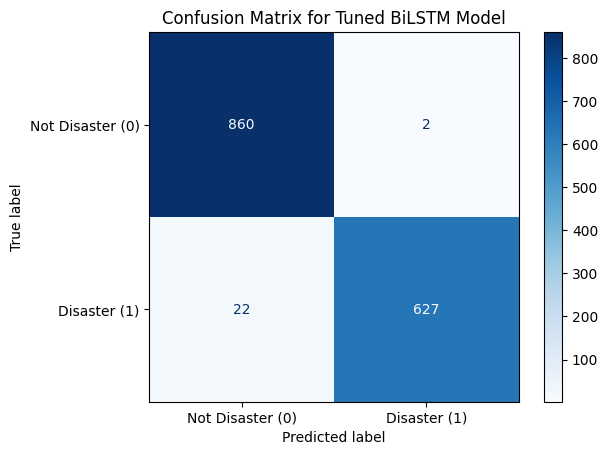

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Disaster (0)', 'Disaster (1)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Tuned BiLSTM Model")
plt.show()


#### Tuned BiLSTM Confusion Matrix Summary

We can see that the tuned model did perform better on the validation data, but we are still seeing the same pattern of many more false negatives to false positives.

### Predict on Test Data (Tuned BiLSTM)

Our F1 score for the validation data was once again very high at 0.9790 and we will now predict on the test data and submit the predictions to Kaggle.

In [ ]:
test_text = tf.convert_to_tensor(df_test_data['clean_text'].values, dtype=tf.string)
preds = best_model.predict(test_text)
preds_binary = (preds > 0.5).astype(int).flatten()

102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step


In [ ]:
submission_LSTM_bidir_tuned = pd.DataFrame({
    'id': df_test_data['id'],
    'target': preds_binary
})

submission_LSTM_bidir_tuned.to_csv("submission_lstm_bidir_tuned.csv", index=False)


In [ ]:
files.download('submission_lstm_bidir_tuned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
best_model.save("models/best_lstm_bidir_tuned.keras")

#### Submission Score

The tuning of hyperparameters did slightly improve the models performance with an F1 score of 0.75666 on the testing data. That being said, we are still seeing a relatively low F1 score in comparison to the validation set.

## GRU Model

Because we are seeing a gap in the F1 score, we are going to simplify the architecture by using GRU instead of LSTM and see if the simpler model performs better. We will still use the bidirectional wrapper and the initial setup will be the same as the base BiLSTM.

In [378]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

### Build & Compile the BiGRU Model

In [379]:
tf.random.set_seed(SEED)
model_gru = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [380]:
model_gru.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.F1Score(name='f1_score', average='micro', threshold=0.5)
    ]
)

### Fit the BiGru Model

In [381]:
checkpoint_gru = tf.keras.callbacks.ModelCheckpoint(
    "models/best_model_GRU_bidirectional.keras",
    monitor="val_f1_score",
    mode="max",
    save_best_only=True,
    save_weights_only=False,
    verbose = 1
)

earlystop_gru = tf.keras.callbacks.EarlyStopping(
    monitor="val_f1_score",
    mode="max",
    patience=3,
    restore_best_weights=True,
    verbose = 1
)

In [382]:
history_gru = model_gru.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint_gru, earlystop_gru]
)


Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6733 - f1_score: 0.3900 - loss: 0.6041
Epoch 1: val_f1_score improved from -inf to 0.82383, saving model to /content/drive/My Drive/my_models/best_model_GRU_bidirectional.keras
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.6736 - f1_score: 0.3913 - loss: 0.6037 - val_accuracy: 0.8610 - val_f1_score: 0.8238 - val_loss: 0.3527
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8626 - f1_score: 0.8325 - loss: 0.3424
Epoch 2: val_f1_score improved from 0.82383 to 0.87927, saving model to /content/drive/My Drive/my_models/best_model_GRU_bidirectional.keras
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8626 - f1_score: 0.8325 - loss: 0.3425 - val_accuracy: 0.9040 - val_f1_score: 0.8793 - val_loss: 0.2577
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8932 - f1_score: 0.8656 - loss: 0.2675
Epoch 3: val_f1_score improved from 0.87927 to 0.92184, saving model to /content/

In [383]:
with open('models/history_gru_bidirectional.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [384]:
#Load History (Needed if in New Session)
with open('models/history_gru_bidirectional.pkl', 'rb') as f:
    history_dict = pickle.load(f)

### Evaluate Plots of GRU Model

In [385]:
train_f1_gru = history_gru.history['f1_score']
val_f1_gru = history_gru.history['val_f1_score']
epochs_range = range(1, len(train_f1_gru) + 1)

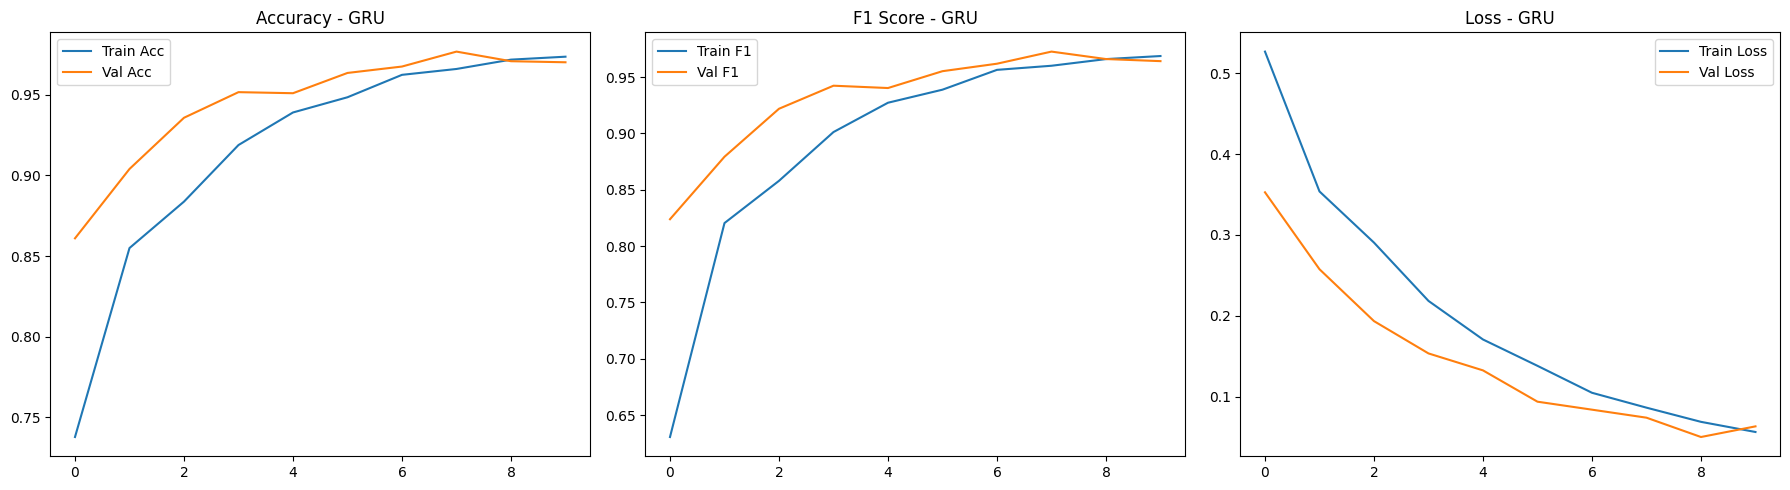

In [386]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axs[0].plot(history_gru.history['accuracy'], label='Train Acc')
axs[0].plot(history_gru.history['val_accuracy'], label='Val Acc')
axs[0].set_title('Accuracy - GRU')
axs[0].legend()

# F1 Score
axs[1].plot(history_gru.history['f1_score'], label='Train F1')
axs[1].plot(history_gru.history['val_f1_score'], label='Val F1')
axs[1].set_title('F1 Score - GRU')
axs[1].legend()

# Loss
axs[2].plot(history_gru.history['loss'], label='Train Loss')
axs[2].plot(history_gru.history['val_loss'], label='Val Loss')
axs[2].set_title('Loss - GRU')
axs[2].legend()

plt.tight_layout()
plt.show()

#### Evaluation Summary
We're seeing a very similar shape in each of the plots as we saw with the BiLSTM model, however with the BiGRU architecture, scores began to flatten out at the 8th epoch versus the 10th in the BiLSTM.

### Build a Confusion Matrix (BiGRU)

We'll next look at the confusion matrix to inspect the distribution of false positives and false negatives.

In [387]:
model_gru_best = keras.models.load_model('models/best_model_GRU_bidirectional.keras')


In [388]:
y_true_gru = []
y_pred_gru = []

for text_batch, label_batch in val_dataset:
    preds = model_gru_best.predict(text_batch)
    y_true_gru.extend(label_batch.numpy())
    y_pred_gru.extend((preds > 0.5).astype("int").flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

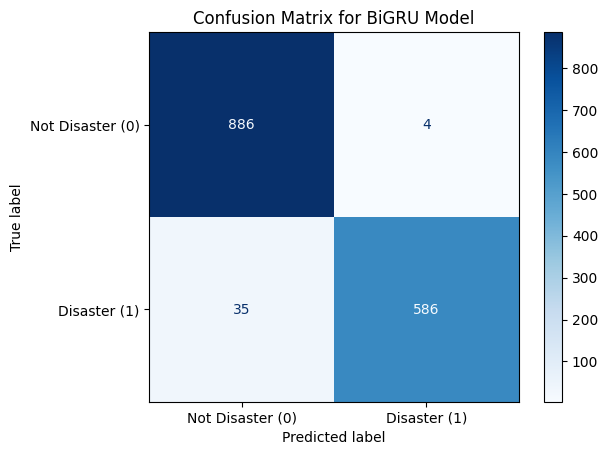

In [389]:
cm_gru = confusion_matrix(y_true_gru, y_pred_gru)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gru, display_labels=['Not Disaster (0)', 'Disaster (1)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for BiGRU Model")
plt.show()


#### BiGRU Confusion Matrix Summary
Like the BiLSTM before it, there are more false negatives than false positives. This architecture produced slightly more false negatives than the untuned BiLSTM (35 vs 30) and slightly less false positives than the untuned BiLSTM (4 vs 5).

### Predict on the Test Data (BiGRU)

In [390]:
df_test_data['clean_text'] = df_test_data['text'].apply(clean_tweet)

In [391]:
test_text = df_test_data['clean_text']
pred_gru_bidir = model_gru_best.predict(np.array(test_text))

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [392]:
submission_gru_bidir = pd.DataFrame({
    'id': df_test_data['id'],
    'target': (pred_gru_bidir > 0.5).astype(int).flatten()
})

In [393]:
submission_gru_bidir.to_csv('submission_gru_bidir.csv', index=False)

In [395]:
files.download('submission_gru_bidir.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Submission Score Summary

The BiGRU architecture did not perform as well as the tuned BiLSTM, but it did out perform the base BiLSTM with an F1 score of 0.75329.

# Results

When comparing the confusion matrices for the three models, we can see that the Tuned BiLSTM performed the best on the validation dataset, with less false positives and false negatives than the other two models. All three models tended to have a harder time identify disaster tweets versus not disaster tweets which can be seen in the fact that they all have much higher false negative rates than false positive rates. 30 to 5 for the original bidirectional LSTM, 22 to 2 for the tuned bidirectional LSTM and 35 to 4 for the bidirectional GRU.

The Tuned BiLSTM performed better not only on the validation data but on the testing data as well and achieved the highest F1 score of the three at .75666. That being said, the F1 score for the testing data was still quite a bit lower and suggests further improvements could be made.


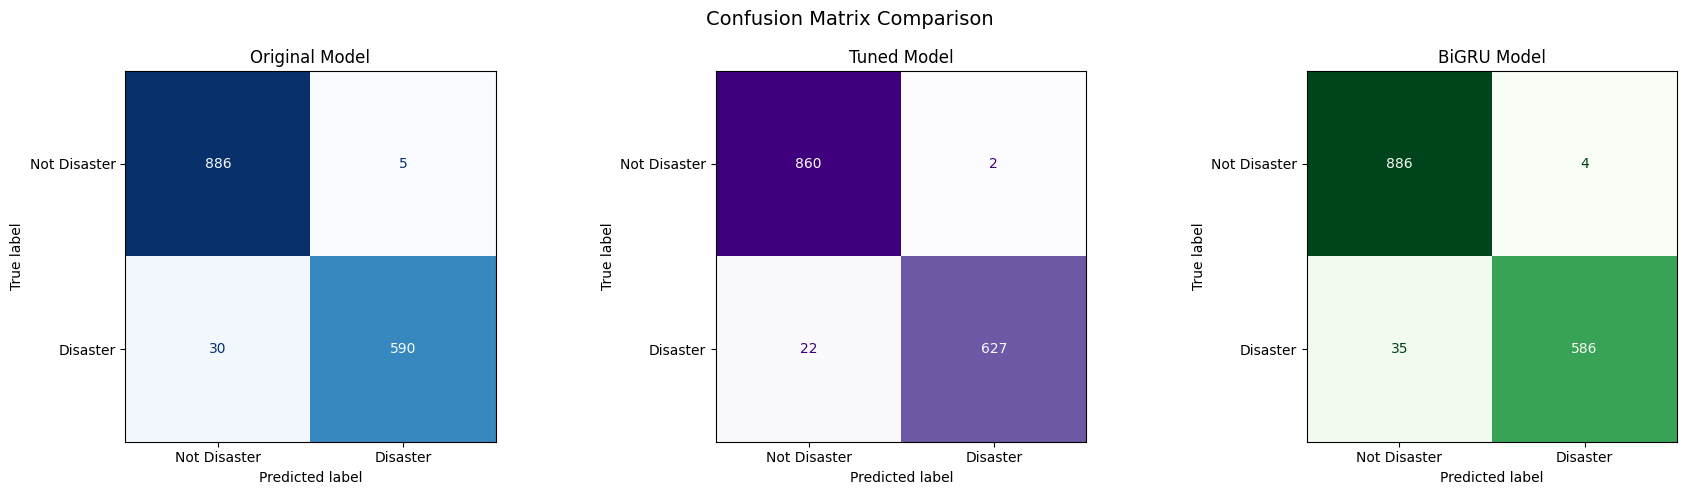

In [396]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#Original BiLSTM
cm_orig = confusion_matrix(y_true_og, y_pred_og)
disp_orig = ConfusionMatrixDisplay(confusion_matrix=cm_orig, display_labels=["Not Disaster", "Disaster"])
disp_orig.plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Original Model")

# Tuned BiLSTM
cm_tuned = confusion_matrix(y_true, y_pred)
disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=["Not Disaster", "Disaster"])
disp_tuned.plot(ax=axes[1], cmap="Purples", colorbar=False)
axes[1].set_title("Tuned Model")

# BiGRU model
cm_gru = confusion_matrix(y_true_gru, y_pred_gru)
disp_gru = ConfusionMatrixDisplay(confusion_matrix=cm_gru, display_labels=["Not Disaster", "Disaster"])
disp_gru.plot(ax=axes[2], cmap="Greens", colorbar=False)
axes[2].set_title("BiGRU Model")

plt.suptitle("Confusion Matrix Comparison", fontsize=14)
plt.tight_layout()
plt.show()

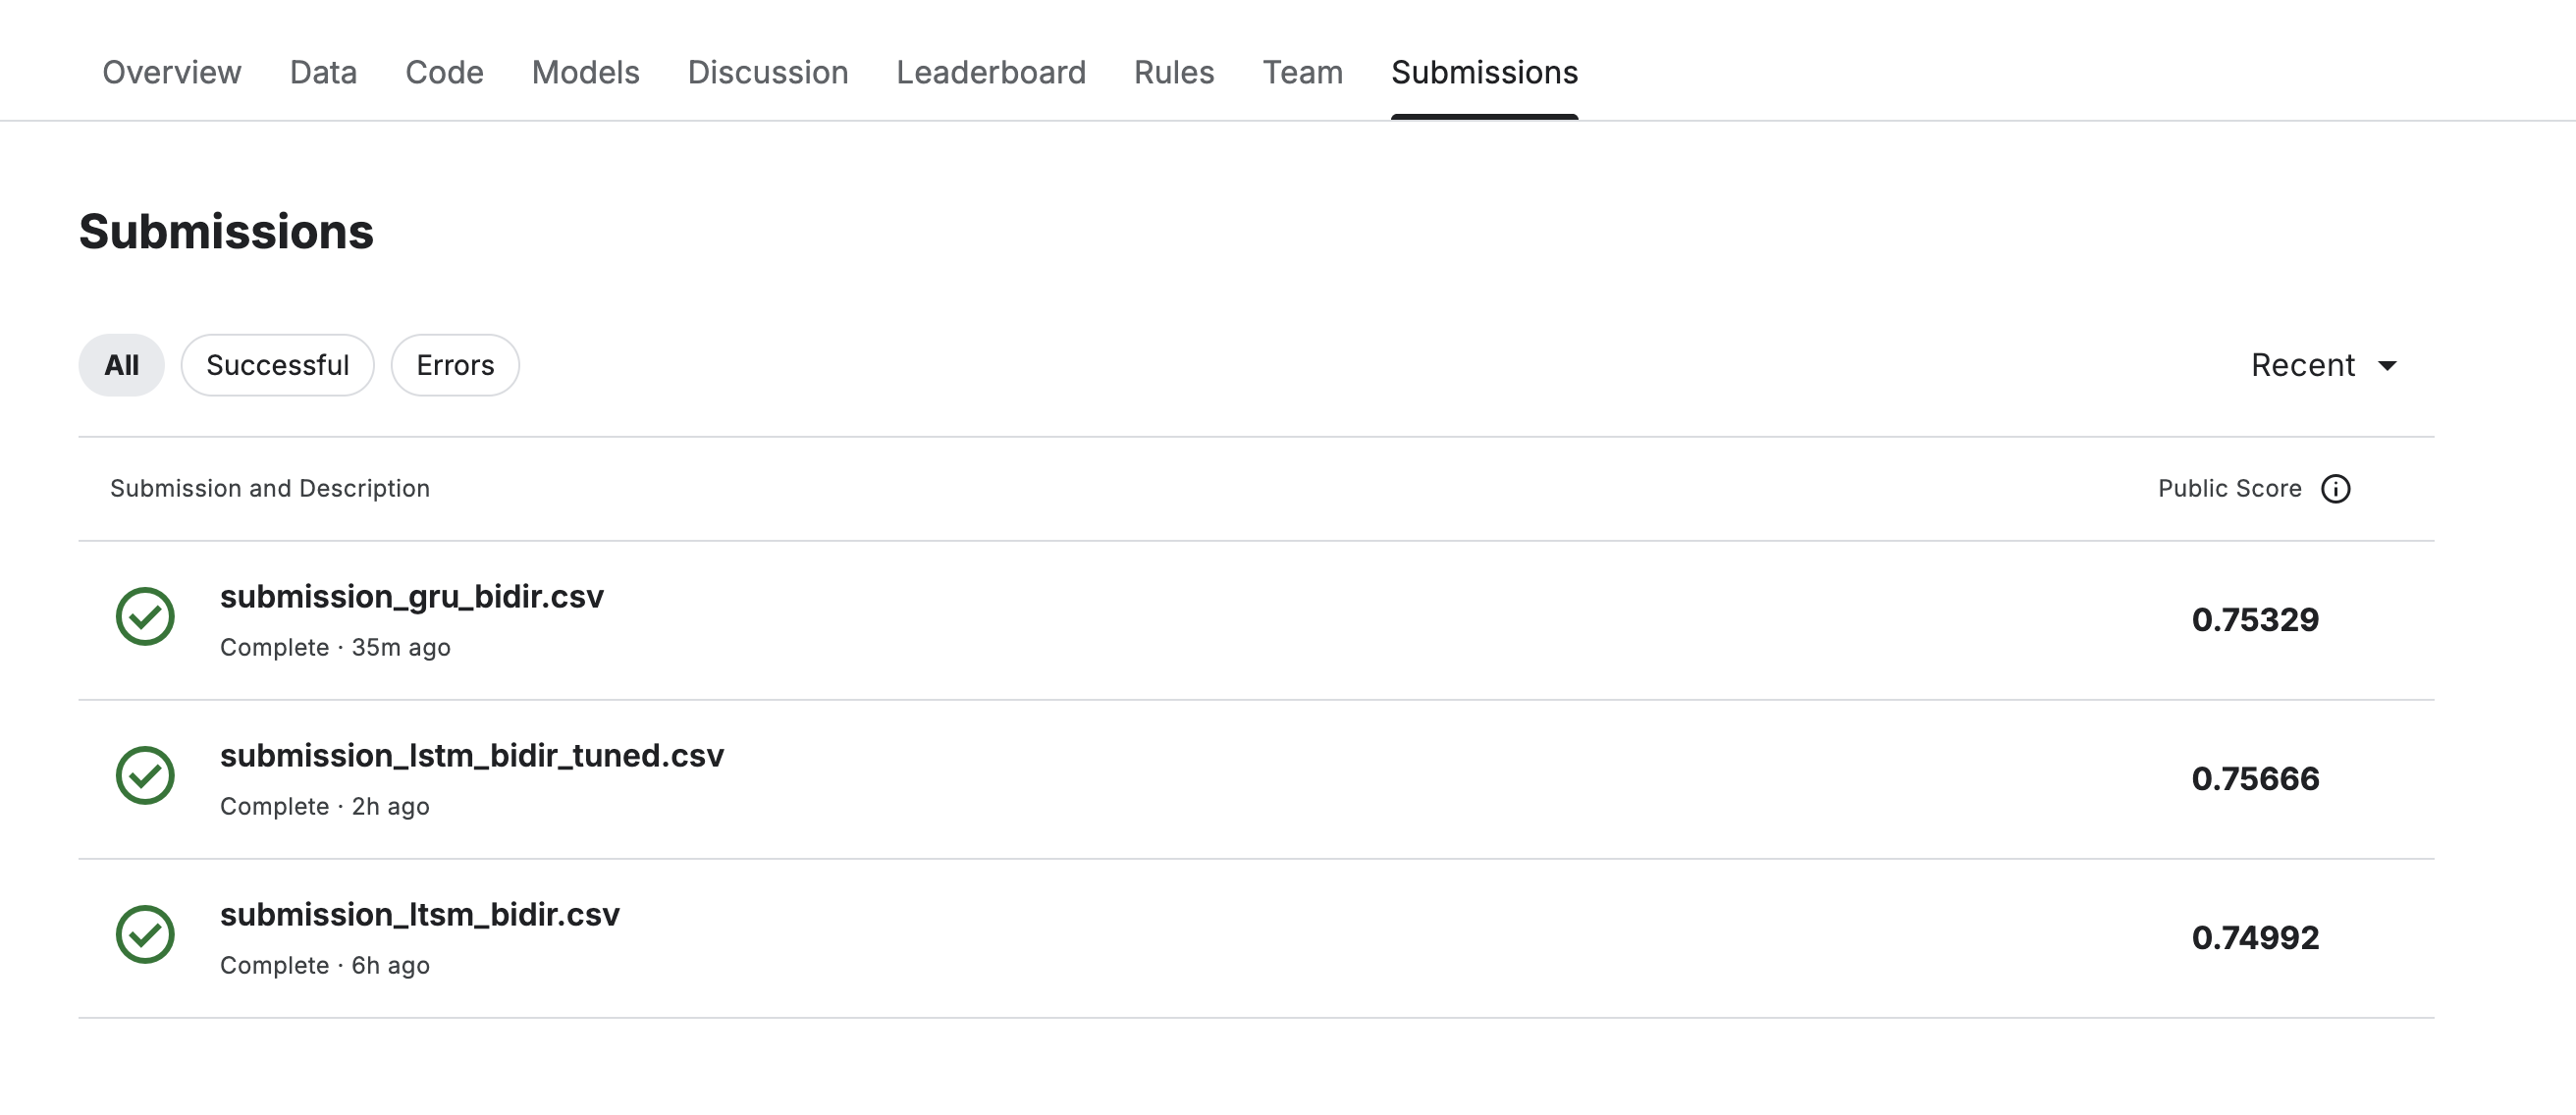

# Conclusions

While the tuned BiLSTM model performed well, there are still several potential improvements worth exploring. Further data cleaning such as handling emojis, correcting informal slang and creating a custom stopword list could help better capture the tone and context of the disaster-related tweets. From a modeling perspective, additional tuning such as including regularization techniques or pretrained embeddings may improve the model performance. In addition, while the base BiGRU didn't perform as well as the tuned BiLSTM, it did perform better than the base BiLSTM and therefore it might be worth adjusting the hyperparameters on that model to see if the F1 score improves. Finally, exploring other architectures such as a stacked LSTMs may lead to further improvements in predictive performance.  

# References

https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets/notebook

https://www.kaggle.com/code/jagdmir/tweet-analysis-ann-bert-cnn-n-gram-cnn

https://www.geeksforgeeks.org/python-efficient-text-data-cleaning/

https://pub.aimind.so/a-comprehensive-guide-to-text-preprocessing-for-twitter-data-getting-ready-for-sentiment-analysis-e7f91cd03671

https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/

https://www.tensorflow.org/text/tutorials/text_classification_rnn

https://www.tensorflow.org/api_docs/python/tf/keras/metrics/F1Score

https://www.tensorflow.org/tutorials/keras/keras_tuner


